## Data segementation and Masking

### Additional libraries installed locally
 - pip install rasterio
 - conda install pytorch torchvision -c pytorch
 - pip install git+https://github.com/facebookresearch/segment-anything.git
 -  pip install opencv-python pycocotools matplotlib onnxruntime onnx
 -  pip install scikit-image
 -  pip install imantics
 -  pip install segment-geospatial

#### Installation of GDAL 
- I followed this link https://medium.com/@vascofernandes_13322/how-to-install-gdal-on-macos-6a76fb5e24a4 (Did not upgrade pip to pip3 in the blog)

#### Mask & Segementation Generation Methods:

Tried out different mask generation techniques. Below are the references.
- 1 . Segment Anything Model (SAM)
- 2 . DIUx-Xview Masking and Segmentation Help Code

## Setup 

In [60]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
import json

import rasterio

import glob
import geopandas as gpd
import fiona
import warnings

import supervision as sv
import onnxruntime

import torch
import cv2
#from os import path, walk, makedirs
#from sys import exit, stderr

#from cv2 import fillPoly, imwrite
#import numpy as np

from skimage.io import imread
from tqdm import tqdm
import imantics 
import sys
sys.path.append("..")

from osgeo import gdal
from osgeo.gdalconst import *


import shapely.geometry as sg
import shapely.ops as so
from shapely import wkt
from shapely.geometry import mapping, Polygon

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
from rasterio.plot import show
from rasterio.mask import mask

from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
import leafmap
#from samgeo import tms_to_geotiff
#from samgeo.text_sam import LangSAM
from lang_sam import LangSAM
from PIL import Image

from jupyter_bbox_widget import BBoxWidget
%matplotlib inline

In [54]:
onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    

### Util Functions

In [36]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [37]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

### Setting the Image location

In [4]:
CURR_DIR = os.getcwd()
print("CURR_DIR : ", CURR_DIR)
os.chdir('../../')

CURR_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/03_data_engineering
CURR_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio


In [38]:
BASE_DATA_DIR = os.getcwd()+'/data'
print("BASE_DIR : ", BASE_DATA_DIR)
DATA_DIR = BASE_DATA_DIR +'/xview_building_damage/images/'
print("DATA_DIR : ", DATA_DIR)
SAM_CKPT_DIR=BASE_DATA_DIR +'/utils/'
print("SAM_CKPT_DIR : ", SAM_CKPT_DIR)

BASE_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data
DATA_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/images/
SAM_CKPT_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/utils/


### Reading and Displaying the image sample

In [39]:
sample_image = cv2.imread(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

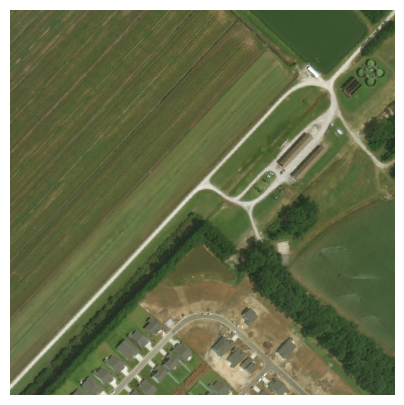

In [91]:
plt.figure(figsize=(5,5))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

## Method 1: Segement Anything Model (SAM)

#### Helper Functions

In [64]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

### Automatic mask generation using SAM

In [41]:
sam_checkpoint = SAM_CKPT_DIR+"sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [42]:
masks = mask_generator.generate(sample_image)

In [43]:
print(len(masks))
print(masks[0].keys())

91
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


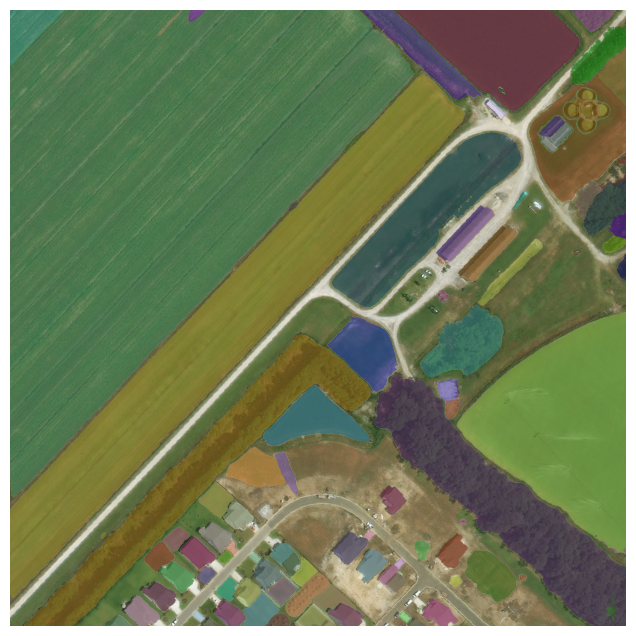

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(sample_image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [45]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(sample_image, detections)

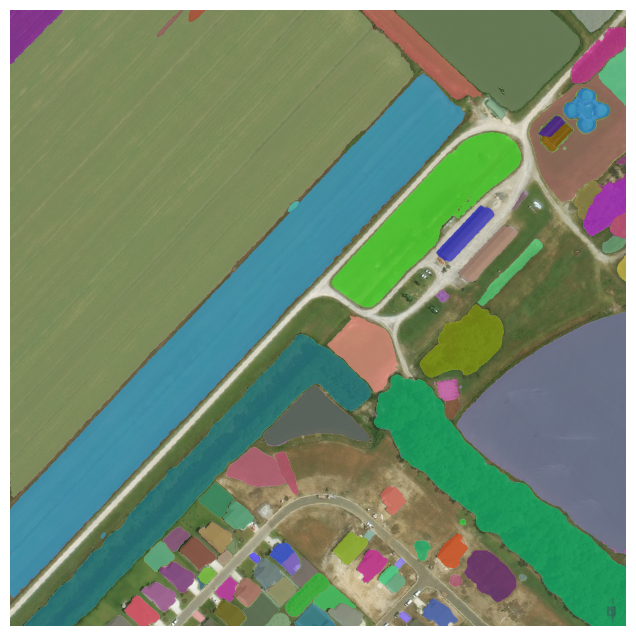

In [46]:
plt.figure(figsize=(8,8))
plt.imshow(annotated_image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Generate Masks with point coordinate

In [83]:
def get_centroid(image_wkt):
    pnt= wkt.loads(image_wkt)
   # print(pnt.centroid)  # POINT (-58.49270000000001 -34.5814)
    #print(pnt.centroid.coords[0])
    return pnt.centroid.coords[0]

In [85]:
def generate_point_mask_sam(img_wkt):
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(sample_image)
    
    input_point = np.array([list(get_centroid(img_wkt))])
    input_label = np.array([1])
    
    masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )
    return masks, scores, logits

#### Example 1

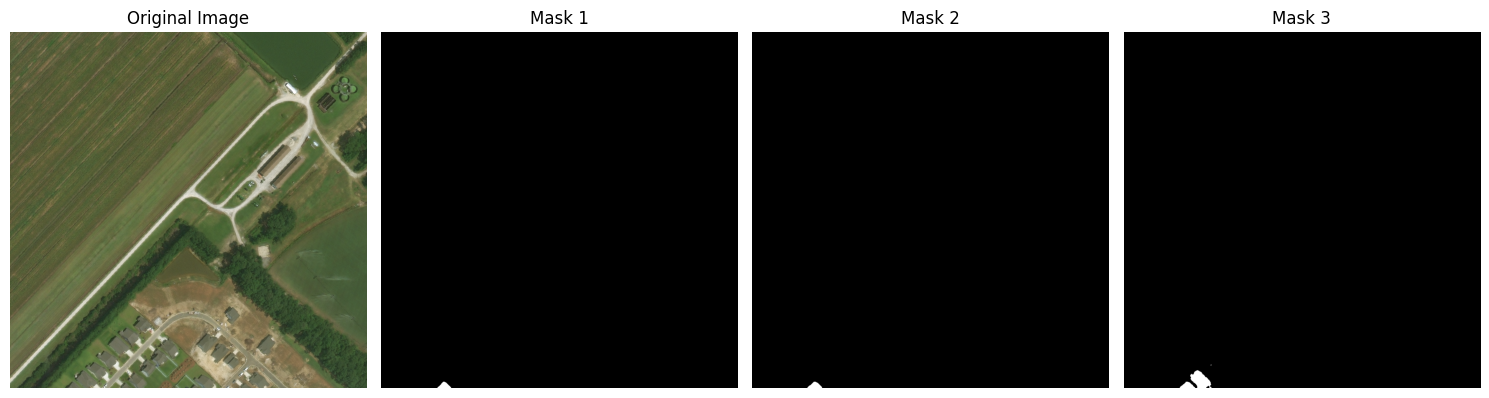

In [86]:
img_wkt='POLYGON ((165.8047937900907 1024, 182.0332860602138 1006.599835682965, 200.4208694653204 1024, 165.8047937900907 1024))'
masks, scores, logits = generate_point_mask_sam(img_wkt)
display_image_with_masks(sample_image,masks)

#### Example 2

Mask with highest score :  0.97487617


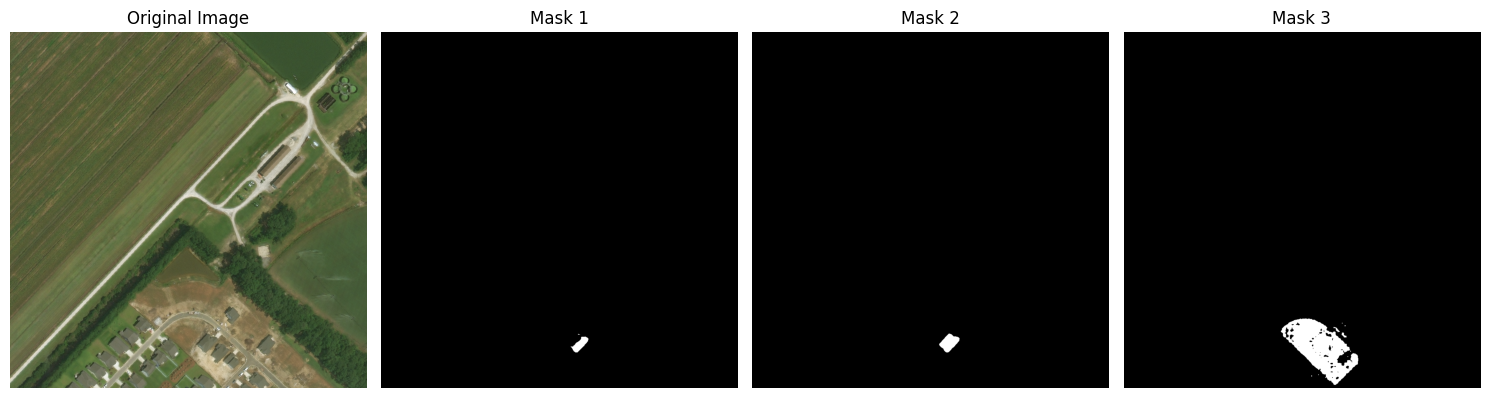

In [90]:
img_wkt='POLYGON ((537.7406675596347 903.5297745013861, 562.0834059648193 923.8919393308802, 595.7651823745088 883.6269066229332, 591.7846087988181 877.9622442267582, 583.8234616474371 877.3498482920365, 582.1509978789109 879.3285100279236, 579.2052687248859 876.898283475853, 573.5347401033877 881.5378068934424, 575.5231072823545 871.964187142861, 568.6006437703958 867.6928798695247, 565.5076281586695 868.797528302284, 536.9340553646266 899.5803979618457, 537.7406675596347 903.5297745013861))'
masks, scores, logits = generate_point_mask_sam(img_wkt)
display_image_with_masks(sample_image,masks)

### Language SAM

- Reference: https://github.com/luca-medeiros/lang-segment-anything
- Sample notebook: https://github.com/luca-medeiros/lang-segment-anything/blob/main/example_notebook/getting_started_with_lang_sam.ipynb

In [61]:
langSam = LangSAM()

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /Users/yaminigotimukul/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /Users/yaminigotimukul/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████████████████████████████████| 2.39G/2.39G [00:26<00:00, 97.0MB/s]


In [63]:
image_pil = Image.open(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png').convert("RGB")
text_prompt = "building"
masks, boxes, phrases, logits = langSam.predict(image_pil, text_prompt)

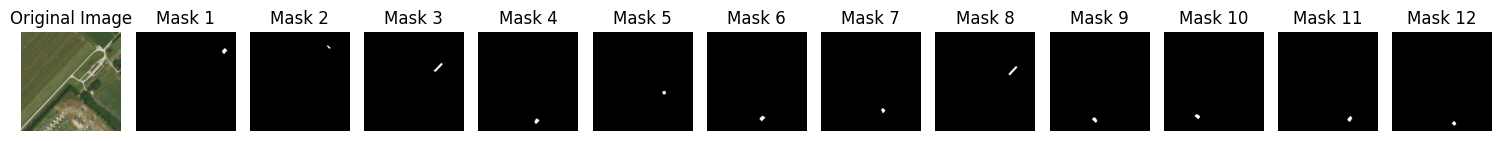

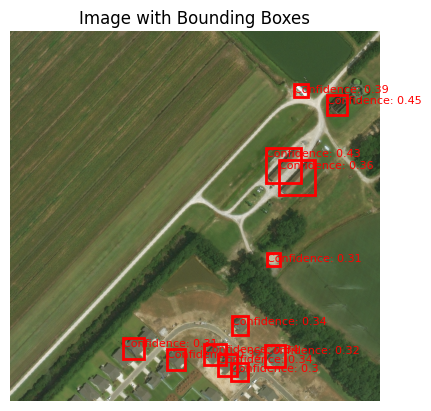

Bounding Boxes:
Box 1: tensor([878.0059, 175.2028, 934.4541, 231.0076])
Box 2: tensor([787.5923, 145.8848, 824.2753, 180.9293])
Box 3: tensor([709.5883, 321.9749, 805.3015, 419.6696])
Box 4: tensor([575.4250, 894.4688, 629.2781, 953.3700])
Box 5: tensor([710.5096, 612.4838, 746.1760, 650.3259])
Box 6: tensor([535.8916, 864.9682, 597.0327, 923.1431])
Box 7: tensor([615.1730, 789.3083, 658.3136, 840.4736])
Box 8: tensor([745.8591, 355.5090, 844.5344, 453.7743])
Box 9: tensor([433.2847, 880.6849, 484.8298, 938.3888])
Box 10: tensor([312.3209, 849.1183, 371.5606, 906.3582])
Box 11: tensor([707.1786, 869.5092, 761.0660, 929.3872])
Box 12: tensor([611.9665, 919.3313, 658.4349, 969.1060])

Detected Phrases:
Phrase 1: building
Phrase 2: building
Phrase 3: building
Phrase 4: building
Phrase 5: building
Phrase 6: building
Phrase 7: building
Phrase 8: building
Phrase 9: building
Phrase 10: building
Phrase 11: building
Phrase 12: building

Confidence:
Logit 1: 0.44749122858047485
Logit 2: 0.389476

In [65]:
if len(masks) == 0:
    print(f"No objects of the '{text_prompt}' prompt detected in the image.")
else:
    # Convert masks to numpy arrays
    masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

    # Display the original image and masks side by side
    display_image_with_masks(image_pil, masks_np)

    # Display the image with bounding boxes and confidence scores
    display_image_with_boxes(image_pil, boxes, logits)

    # Save the masks
    for i, mask_np in enumerate(masks_np):
        mask_path = f"image_mask_{i+1}.png"
        save_mask(mask_np, mask_path)

    # Print the bounding boxes, phrases, and logits
    print_bounding_boxes(boxes)
    print_detected_phrases(phrases)
    print_logits(logits)

### Generate Segmentation Mask with Bounding Box

In [106]:
mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

default_box = {'x': 0, 'y': 800, 'width': 600, 'height': 200, 'label': ''}
widget = BBoxWidget()
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

#box = np.array([926,0,626,0])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

/var/folders/_n/997tnw7n3tdg9z81cr8j96dc0000gn/T/ipykernel_21932/1068391544.py:1: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
/var/folders/_n/997tnw7n3tdg9z81cr8j96dc0000gn/T/ipykernel_21932/1068391544.py:2: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)


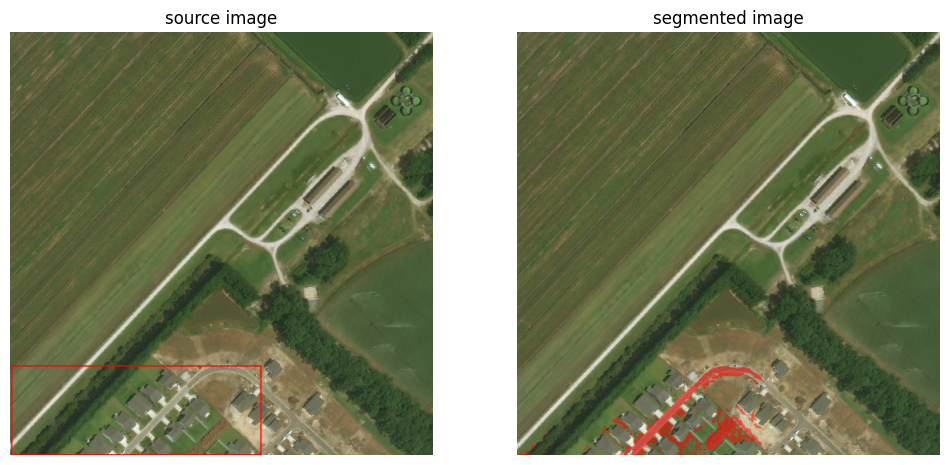

In [107]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Generating Mask using Rasterio

/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


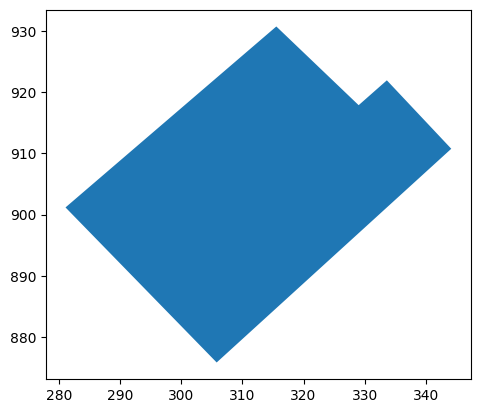

In [133]:
from shapely.wkt import loads
image = rasterio.open(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
#bldg_poly = loads('POLYGON ((-79.04505996336113 33.65424116148868, -79.04492419817866 33.65413263811787, -79.04483519076582 33.6541312299608, -79.04475819075903 33.65419524958159, -79.0449498859919 33.65433960221093, -79.04499509050937 33.65430710163625, -79.04499216420382 33.65428986045841, -79.04501908647336 33.65427253680217, -79.04503338621484 33.65425612280632, -79.04505996336113 33.65424116148868))')
bldg_poly = loads('POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))')
p = gpd.GeoSeries(bldg_poly)
p.plot()
plt.show()

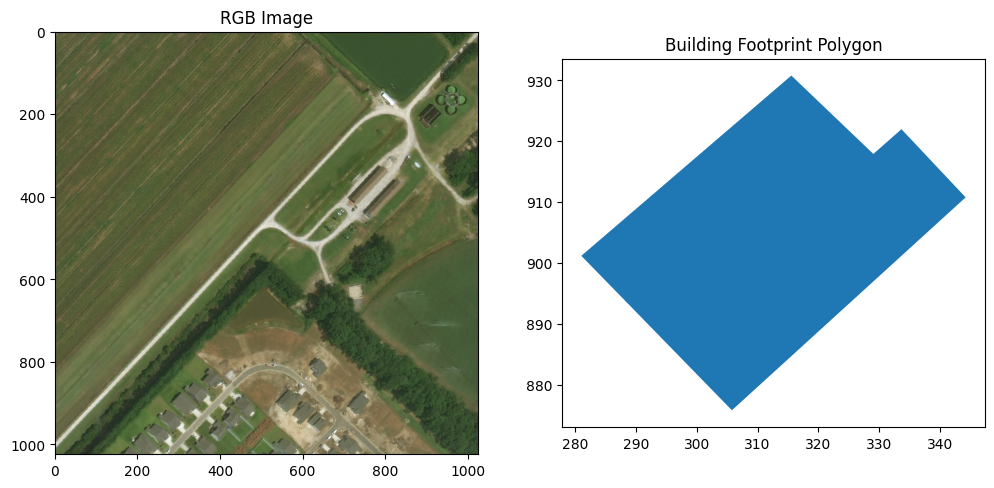

In [139]:
# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot RGB image
show(image, ax=ax1)
ax1.set_title('RGB Image')

# Plot building footprint
p.plot(ax=ax2)
ax2.set_title('Building Footprint Polygon')

plt.show();

/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/json

### Converting the image to geotiff

In [7]:
JSON_DIR = BASE_DATA_DIR+'/xview_building_damage/json/'
geo_json_bd=JSON_DIR+'xview_geotransforms.json'
geo_transforms = json.load(open(geo_json_bd,"r"))
geomatrix = geo_transforms["hurricane-florence_00000008_pre_disaster.png"][0]
projection = geo_transforms["hurricane-florence_00000008_pre_disaster.png"][1]

In [10]:
inDs = gdal.Open(DATA_DIR+"hurricane-florence_00000008_pre_disaster.png")

rows=inDs.RasterYSize
columns=inDs.RasterXSize

outDs = gdal.GetDriverByName('GTiff').Create("hurricane-florence_00000008_pre_disaster.png", rows, columns, 3, GDT_Int16)

for i in range(1,4):
    outBand = outDs.GetRasterBand(i)
    outData = np.array(inDs.GetRasterBand(i).ReadAsArray())
    outBand.WriteArray(outData, 0, 0)
    outBand.FlushCache()
    outBand.SetNoDataValue(-99)

outDs.SetGeoTransform(geomatrix)
outDs.SetProjection(projection)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x2e3c6e370> >

## Method 2: DIUx-xView Masking and Segementation

### Spliting the images by disaster

The below code is part of the baseline model code and uses separate the different disasters.

In [ ]:
print("Current Dir",os.getcwd())
!python src/utils/mask_generators/split_into_disasters.py --input data/xview_building_damage/challenge/train --output data/xview_building_damage/challenge/output

### Creating Masks using Challenge Baseline Script 

This code is adapted from the original challenge baseline code base for generating masks and been modified slightly to generate the masks. The link for the original code is https://github.com/DIUx-xView/xView2_baseline/blob/master/utils/mask_polygons.py  

In [31]:
print(cv2.__version__)

4.8.0


In [34]:
#!python src/utils/mask_generators/mask_polygons.py --input data/xview_building_damage/challenge/output --single-file --border 2
def get_dimensions(file_path):
    """
    :param file_path: The path of the file 
    :return: returns (width,height,channels)
    """
    # Open the image we are going to mask
    pil_img = imread(file_path)
    img = np.array(pil_img)
    w, h, c = img.shape
    return (w, h, c)

def mask_polygons_separately(size, shapes):
    """
    :param size: A tuple of the (width,height,channels)
    :param shapes: A list of points in the polygon from get_feature_info
    :returns: a dict of masked polygons with the shapes filled in from cv2.fillPoly
    """
    # For each WKT polygon, read the WKT format and fill the polygon as an image
    masked_polys = {}

    for u in shapes:
        sh = shapes[u]
        mask_img = np.zeros(size, np.uint8)
        i = fillPoly(mask_img, [sh], (255, 255, 255))
        masked_polys[u] = i

    return masked_polys

def mask_polygons_together(size, shapes):
    """
    :param size: A tuple of the (width,height,channels)
    :param shapes: A list of points in the polygon from get_feature_info
    :returns: A numpy array with the polygons filled 255s where there's a building and 0 where not 
    """
    # For each WKT polygon, read the WKT format and fill the polygon as an image
    mask_img = np.zeros(size, np.uint8)

    for u in shapes:
        blank =  np.zeros(size, np.uint8)
        poly = shapes[u] 
        fillPoly(blank, [poly], (1, 1, 1))
        mask_img += blank
    
    # Here we are taking the overlap (+=) and squashing it back to 0
    mask_img[mask_img > 1] = 0

    # Finally we are taking all 1s and making it pure white (255)
    mask_img[mask_img == 1] = 255

    return mask_img

def mask_polygons_together_with_border(size, shapes, border):
    """
    :param size: A tuple of the (width,height,channels)
    :param shapes: A list of points in the polygon from get_feature_info
    :returns: a dict of masked polygons with the shapes filled in from cv2.fillPoly
    """

    # For each WKT polygon, read the WKT format and fill the polygon as an image
    mask_img = np.zeros(size, np.uint8)

    for u in shapes:
        blank =  np.zeros(size, np.uint8)
        # Each polygon stored in shapes is a np.ndarray
        poly = shapes[u]
        
        # Creating a shapely polygon object out of the numpy array 
        polygon = Polygon(poly)

        # Getting the center points from the polygon and the polygon points
        (poly_center_x, poly_center_y) = polygon.centroid.coords[0]
        polygon_points = polygon.exterior.coords

        # Setting a new polygon with each X,Y manipulated based off the center point
        shrunk_polygon = []
        for (x,y) in polygon_points:
            if x < poly_center_x:
                x += border
            elif x > poly_center_x:
                x -= border

            if y < poly_center_y:
                y += border
            elif y > poly_center_y:
                y -= border

            shrunk_polygon.append([x,y])
        
        # Transforming the polygon back to a np.ndarray
        ns_poly = np.array(shrunk_polygon, np.int32)
  
        # Filling the shrunken polygon to add a border between close polygons
        fillPoly(blank, [ns_poly], (1, 1, 1))
        mask_img += blank
    
    mask_img[mask_img > 1] = 0
    mask_img[mask_img == 1] = 255
    return mask_img

def save_masks(masks, output_path, mask_file_name):
    """
    :param masks: dictionary of UID:masked polygons from mask_polygons_separately()
    :param output_path: path to save the masks
    :param mask_file_name: the file name the masks should have 
    """
    # For each filled polygon, write out a separate file, increasing the name
    for m in masks:
        final_out = path.join(output_path,
                              mask_file_name + '_{}.png'.format(m))
        imwrite(final_out, masks[m])

def save_one_mask(masks, output_path, mask_file_name):
    """
    :param masks: list of masked polygons from the mask_polygons_separately function 
    :param output_path: path to save the masks
    :param mask_file_name: the file name the masks should have 
    """
    # For each filled polygon, write the mask shape out to the file per image
    mask_file_name = path.join(output_path, mask_file_name + '.png')
    imwrite(mask_file_name, masks)
    

def read_json(json_path):
    """
    :param json_path: path to load json from
    :returns: a python dictionary of json features
    """
    annotations = json.load(open(json_path))
    return annotations


def get_feature_info(feature):
    """
    :param feature: a python dictionary of json labels
    :returns: a list mapping of polygons contained in the image 
    """
    # Getting each polygon points from the json file and adding it to a dictionary of uid:polygons
    props = {}

    for feat in feature['features']['xy']:
        feat_shape = wkt.loads(feat['wkt'])
        coords = list(mapping(feat_shape)['coordinates'][0])
        props[feat['properties']['uid']] = (np.array(coords, np.int32))

    return props


def mask_chips(json_path, images_directory, output_directory, single_file, border):
    """
    :param json_path: path to find multiple json files for the chips
    :param images_directory: path to the directory containing the images to be masked
    :param output_directory: path to the directory where masks are to be saved
    :param single_file: a boolean value to see if masks should be saved a single file or multiple
    """
    # For each feature in the json we will create a separate mask
    # Getting all files in the directory provided for jsons
    jsons = [j for j in next(walk(json_path))[2] if '_pre' in j]

    # After removing non-json items in dir (if any)
    for j in tqdm([j for j in jsons if j.endswith('json')],
                  unit='poly',
                  leave=False):
        # Our chips start off in life as PNGs
        chip_image_id = path.splitext(j)[0] + '.png'
        mask_file = path.splitext(j)[0]

        # Loading the per chip json
        j_full_path = path.join(json_path, j)
        chip_json = read_json(j_full_path)

        # Getting the full chip path, and loading the size dimensions
        chip_file = path.join(images_directory, chip_image_id)
        chip_size = get_dimensions(chip_file)

        # Reading in the polygons from the json file
        polys = get_feature_info(chip_json)

        # Getting a list of the polygons and saving masks as separate or single image files
        if len(polys) > 0:
            if single_file:
                if border > 0:
                    masked_polys = mask_polygons_together_with_border(chip_size, polys, border)
                else:
                    masked_polys = mask_polygons_together(chip_size, polys)
                save_one_mask(masked_polys, output_directory, mask_file)
            else:
                masked_polys = mask_polygons_separately(chip_size, polys)
                save_masks(masked_polys, output_directory, mask_file)


import argparse

# Parse command line arguments
parser = argparse.ArgumentParser(
    description=
    """mask_polygons.py: Takes in xBD dataset and masks polygons in the image\n\n
    WARNING: This could lead to hundreds of output images per input\n""")

parser.add_argument('--input',
                    required=True,
                    metavar="/path/to/xBD/",
                    help='Path to parent dataset directory "xBD"')
parser.add_argument('--single-file', 
                    action='store_true',
                    help='use to save all masked polygon instances to a single file rather than one polygon per mask file')
parser.add_argument('--border',
                    default=0,
                    type=int,
                    metavar="positive integer for pixel border (e.g. 1)",
                    help='Positive integer used to shrink the polygon by')

args = parser.parse_args(['--input', 'data/xview_building_damage/challenge/output','--single-file', '--border', '2'])

# Getting the list of the disaster types under the xBD directory
disasters = next(walk(args.input))[1]

for disaster in tqdm(disasters, desc='Masking', unit='disaster'):
    # Create the full path to the images, labels, and mask output directories
    image_dir = path.join(args.input, disaster, 'images')
    json_dir = path.join(args.input, disaster, 'labels')
    output_dir = path.join(args.input, disaster, 'masks')

    if not path.isdir(image_dir):
        print(
            "Error, could not find image files in {}.\n\n"
            .format(image_dir),
            file=stderr)
        exit(2)

    if not path.isdir(json_dir):
        print(
            "Error, could not find labels in {}.\n\n"
            .format(json_dir),
            file=stderr)
        exit(3)

    if not path.isdir(output_dir):
        makedirs(output_dir)

    mask_chips(json_dir, image_dir, output_dir, args.single_file, args.border)

Masking: 100%|████████████████████████████| 10/10 [05:13<00:00, 31.34s/disaster]
